<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test.

    1. Balanceo de las etiquetas
    2. Subconjuntos Train y Test
    3. Normalización de los datos
    Visualización

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [2]:
df= pd.read_csv('features.csv')
print('Las dimensiones del df de características de todos los pacientes es:',df.shape)

Las dimensiones del df de características de todos los pacientes es: (22165, 16)


In [3]:
df.sample(5)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
12680,54.0,92.0,63.20,0.99,-0.59,-0.58,-0.58,-0.02,-0.00,-0.01,-0.81,-0.80,-0.80,1.0,3.0,16.0
9294,92.0,97.0,94.00,1.00,-0.35,-0.33,-0.34,-0.21,-0.20,-0.21,0.92,0.93,0.92,1.0,2.0,11.0
20345,60.0,64.0,62.33,1.00,-0.36,-0.35,-0.36,0.10,0.11,0.10,0.92,0.93,0.93,1.0,2.0,28.0
6680,73.0,76.0,74.60,0.99,-0.06,-0.05,-0.05,0.16,0.17,0.16,-0.98,-0.97,-0.98,1.0,2.0,7.0
10719,52.0,52.0,52.00,1.00,-0.19,-0.19,-0.19,0.29,0.29,0.29,-0.94,-0.93,-0.94,1.0,3.0,14.0


## 1. Balanceo de las etiquetas

#### ETIQUETAS BINARIAS

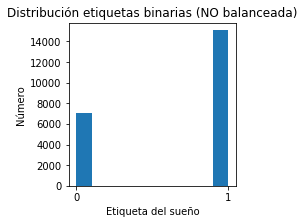

In [4]:
# DF NO BALANCEADO
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias (NO balanceada)')
plt.xlabel("Etiqueta del sueño")
plt.xticks([0,1])
plt.ylabel("Número")
plt.hist(df['Etiquetas binarias'])
plt.show()

In [5]:
labels_bin=df['Etiquetas binarias'] # 0 (0,-1,5) y 1 (1,2,3,4)

lab_0_bin = []
idx_0_bin = []
list_idx_0_bin = []

for l in labels_bin:
    if l==0:
        idx_0_bin.append(True)
    else:
        idx_0_bin.append(False)
list_idx_0_bin.append(df[idx_0_bin])

lab_1_bin = []
idx_1_bin = []
list_idx_1_bin = []

for l in labels_bin:
    if l==1:
        idx_1_bin.append(True)
    else:
        idx_1_bin.append(False)
list_idx_1_bin.append(df[idx_1_bin])

df0_bin = pd.DataFrame()  
for i in range(len(list_idx_0_bin)):
    df0_bin=df0_bin.append(list_idx_0_bin[i])
df1_bin = pd.DataFrame()  
for i in range(len(list_idx_1_bin)):
    df1_bin=df1_bin.append(list_idx_1_bin[i])

#### ETIQUETAS MULTICLASE

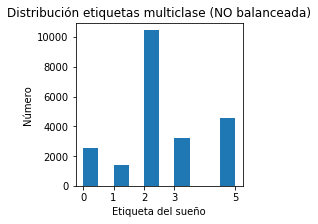

In [6]:
# DF NO BALANCEADO
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas multiclase (NO balanceada)')
plt.xlabel("Etiqueta del sueño")
plt.xticks([0,1,2,3,5])
plt.ylabel("Número")
plt.hist(df['Etiquetas multiclase'])
plt.show()

In [7]:
labels_multi=df['Etiquetas multiclase'] #0 (-1,0), 1, 2, 3 (3,4), 5

lab_0_multi = []
idx_0_multi = []
list_idx_0_multi = []

for l in labels_multi:
    if l==0:
        idx_0_multi.append(True)
    else:
        idx_0_multi.append(False)
list_idx_0_multi.append(df[idx_0_multi])

lab_1_multi = []
idx_1_multi = []
list_idx_1_multi = []

for l in labels_multi:
    if l==1:
        idx_1_multi.append(True)
    else:
        idx_1_multi.append(False)
list_idx_1_multi.append(df[idx_1_multi])

lab_2_multi = []
idx_2_multi = []
list_idx_2_multi = []

for l in labels_multi:
    if l==2:
        idx_2_multi.append(True)
    else:
        idx_2_multi.append(False)
list_idx_2_multi.append(df[idx_2_multi])

lab_3_multi = []
idx_3_multi = []
list_idx_3_multi = []

for l in labels_multi:
    if l==3:
        idx_3_multi.append(True)
    else:
        idx_3_multi.append(False)
list_idx_3_multi.append(df[idx_3_multi])

lab_5_multi = []
idx_5_multi = []
list_idx_5_multi = []

for l in labels_multi:
    if l==5:
        idx_5_multi.append(True)
    else:
        idx_5_multi.append(False)
list_idx_5_multi.append(df[idx_5_multi])


df0_multi = pd.DataFrame()  
for i in range(len(list_idx_0_multi)):
    df0_multi=df0_multi.append(list_idx_0_multi[i])
df1_multi = pd.DataFrame()  
for i in range(len(list_idx_1_multi)):
    df1_multi=df1_multi.append(list_idx_1_multi[i])
df2_multi = pd.DataFrame()  
for i in range(len(list_idx_2_multi)):
    df2_multi=df2_multi.append(list_idx_2_multi[i])
df3_multi = pd.DataFrame()  
for i in range(len(list_idx_3_multi)):
    df3_multi=df3_multi.append(list_idx_3_multi[i])
df5_multi = pd.DataFrame()  
for i in range(len(list_idx_5_multi)):
    df5_multi=df5_multi.append(list_idx_5_multi[i])

##### BALANCEO

In [8]:
n_lab_binarias=[df0_bin['Etiquetas binarias'].value_counts()[0],df1_bin['Etiquetas binarias'].value_counts()[1]]

n_lab_multiclase=[df0_multi['Etiquetas multiclase'].value_counts()[0],df1_multi['Etiquetas multiclase'].value_counts()[1],
      df2_multi['Etiquetas multiclase'].value_counts()[2],df3_multi['Etiquetas multiclase'].value_counts()[3],
      df5_multi['Etiquetas multiclase'].value_counts()[5]]

In [9]:
n_lab=min([min(n_lab_binarias),min(n_lab_multiclase)])

print('\n','Binarias:',n_lab_binarias,'\n','Multiclase:',n_lab_multiclase,'\n','Mínimo:',n_lab,'\n')


 Binarias: [7100, 15065] 
 Multiclase: [2572, 1411, 10436, 3218, 4528] 
 Mínimo: 1411 



Nos creamos dos dataframes distintos: uno con los datos de las etiquetas multiclase balanceados (*df_multi_balanced*) y el otro con los datos de las etiquetas binarias balanceados (*df_bin_balanced*). Se han valanceado todas las clases (tanto binarias como multiclase) al número mínimo de etiquetas de los dos tipos.

In [10]:
n_lab_bin=600 # Restringimos el número de muestras de cada clase debido a la capacidad de computación
df_bin_balanced = pd.DataFrame()
df_bin_balanced=df_bin_balanced.append(df0_bin.sample(n_lab_bin)).append(df1_bin.sample(n_lab_bin))
print('Las dimensiones del df de características con etiquetas binarias balanceadas es:',df_bin_balanced.shape)

n_lab_multi=200 # Restringimos el número de muestras de cada clase debido a la capacidad de computación
df_multi_balanced = pd.DataFrame()
df_multi_balanced=df_multi_balanced.append(df0_multi.sample(n_lab_multi)).append(df1_multi.sample(n_lab_multi)).append(df2_multi.sample(n_lab_multi)).append(df3_multi.sample(n_lab_multi)).append(df5_multi.sample(n_lab_multi))
print('Las dimensiones del df de características con etiquetas multiclase balanceadas es:',df_multi_balanced.shape)

Las dimensiones del df de características con etiquetas binarias balanceadas es: (1200, 16)
Las dimensiones del df de características con etiquetas multiclase balanceadas es: (1000, 16)


ETIQUETAS BINARIAS
Número de valores diferentes que hay para etiquetas binarias: 2 

Número de veces que se toma cada valor de etiquetas binarias:
1.0    600
0.0    600
Name: Etiquetas binarias, dtype: int64 



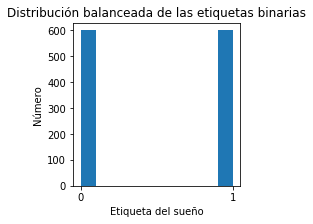

ETIQUETAS MULTICLASE
Número de valores diferentes que hay para etiquetas multiclase: 5 

Número de veces que se toma cada valor de etiquetas multiclase:
5.0    200
3.0    200
2.0    200
1.0    200
0.0    200
Name: Etiquetas multiclase, dtype: int64 



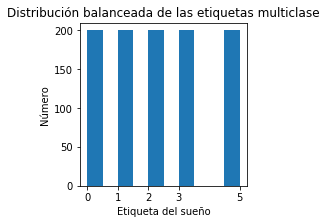

In [11]:
print('\x1b[1;30m'+'ETIQUETAS BINARIAS'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas binarias:',df_bin_balanced['Etiquetas binarias'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas binarias:')
print(df_bin_balanced['Etiquetas binarias'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución balanceada de las etiquetas binarias')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(df_bin_balanced['Etiquetas binarias'])
plt.show()

print('\x1b[1;30m'+'ETIQUETAS MULTICLASE'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas multiclase:',df_multi_balanced['Etiquetas multiclase'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas multiclase:')
print(df_multi_balanced['Etiquetas multiclase'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución balanceada de las etiquetas multiclase')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([-1,0,1,2,3,5])
plt.hist(df_multi_balanced['Etiquetas multiclase'])
plt.show()

In [12]:
print('El porcentaje de datos del que se dispone tras balancear las etiquetas binarias es:',"{0:.2f}".format((df_bin_balanced.shape[0]*100)/df.shape[0]),'%')
print('El porcentaje de datos del que se dispone tras balancear las etiquetas multiclase es:',"{0:.2f}".format((df_multi_balanced.shape[0]*100)/df.shape[0]),'%')

El porcentaje de datos del que se dispone tras balancear las etiquetas binarias es: 5.41 %
El porcentaje de datos del que se dispone tras balancear las etiquetas multiclase es: 4.51 %


## 2. Subconjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [13]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 24 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [0, 10, 22, 26, 15, 25, 18, 17, 21, 6, 5, 3, 7, 30, 19, 12, 13, 4, 8, 20, 16, 2, 24, 29]
7 sujetos de test: [1, 9, 11, 14, 23, 27, 28]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos. Se distinguen diferentes conjuntos en función de si están balanceadas las etiquetas binarias o las multiclase.

#### ETIQUETAS BINARIAS

In [14]:
train_matr = []
test_matr = []
id = df_bin_balanced['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    train_matr.append(df_bin_balanced[idx])

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    test_matr.append(df_bin_balanced[idx])

In [15]:
Train_bin_balanced = pd.DataFrame()
for i in range(len(train_matr)):
    Train_bin_balanced=Train_bin_balanced.append(train_matr[i])

Test_bin_balanced = pd.DataFrame()  
for i in range(len(test_matr)):
    Test_bin_balanced=Test_bin_balanced.append(test_matr[i])

In [16]:
Train_bin_balanced.to_csv('Train_binary.csv', header=True, index=False)
Test_bin_balanced.to_csv('Test_binary.csv', header=True, index=False)

#### ETIQUETAS MULTICLASE

In [17]:
train_matr = []
test_matr = []
id = df_multi_balanced['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    train_matr.append(df_multi_balanced[idx])

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    test_matr.append(df_multi_balanced[idx])

In [18]:
Train_multi_balanced = pd.DataFrame()
for i in range(len(train_matr)):
    Train_multi_balanced=Train_multi_balanced.append(train_matr[i])

Test_multi_balanced = pd.DataFrame()  
for i in range(len(test_matr)):
    Test_multi_balanced=Test_multi_balanced.append(test_matr[i])

In [19]:
Train_multi_balanced.to_csv('Train_multiclass.csv', header=True, index=False)
Test_multi_balanced.to_csv('Test_multiclass.csv', header=True, index=False)

#### SIN BALANCEAR

In [20]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    train_matr.append(df[idx])

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    test_matr.append(df[idx])

In [21]:
Train = pd.DataFrame()
for i in range(len(train_matr)):
    Train=Train.append(train_matr[i])

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    Test=Test.append(test_matr[i])

In [22]:
Train.to_csv('Train.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)

### 3. Normalización de los datos

#### ETIQUETAS BINARIAS

In [23]:
Train_tt_bin_balanced=Train_bin_balanced.copy()
Test_tt_bin_balanced=Test_bin_balanced.copy()

In [24]:
X_train=Train_tt_bin_balanced.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_bin_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_bin_transformed['Etiquetas multiclase'], Train_bin_transformed['Etiquetas binarias'], Train_bin_transformed['ID'] = [Train_bin_balanced['Etiquetas multiclase'].values, Train_bin_balanced['Etiquetas binarias'].values, Train_bin_balanced['ID'].values]

X_test=Test_tt_bin_balanced.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_bin_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_bin_transformed['Etiquetas multiclase'], Test_bin_transformed['Etiquetas binarias'], Test_bin_transformed['ID'] = [Test_bin_balanced['Etiquetas multiclase'].values, Test_bin_balanced['Etiquetas binarias'].values, Test_bin_balanced['ID'].values]

In [25]:
Train_bin_transformed.to_csv('Train_binary_transformed.csv', header=True, index=False)
Test_bin_transformed.to_csv('Test_binary_transformed.csv', header=True, index=False)

#### ETIQUETAS MULTICLASE

In [26]:
Train_tt_multi_balanced=Train_multi_balanced.copy()
Test_tt_multi_balanced=Test_multi_balanced.copy()

In [27]:
X_train=Train_tt_multi_balanced.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_multi_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_multi_transformed['Etiquetas multiclase'], Train_multi_transformed['Etiquetas binarias'], Train_multi_transformed['ID'] = [Train_multi_balanced['Etiquetas multiclase'].values, Train_multi_balanced['Etiquetas binarias'].values, Train_multi_balanced['ID'].values]

X_test=Test_tt_multi_balanced.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_multi_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_multi_transformed['Etiquetas multiclase'], Test_multi_transformed['Etiquetas binarias'], Test_multi_transformed['ID'] = [Test_multi_balanced['Etiquetas multiclase'].values, Test_multi_balanced['Etiquetas binarias'].values, Test_multi_balanced['ID'].values]

In [28]:
Train_multi_transformed.to_csv('Train_multiclass_transformed.csv', header=True, index=False)
Test_multi_transformed.to_csv('Test_multiclass_transformed.csv', header=True, index=False)

#### SIN BALANCEAR

In [29]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [30]:
X_train=Train_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas multiclase'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas multiclase'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas multiclase'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas multiclase'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [31]:
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

### VISUALIZACIÓN

#### ETIQUETAS BINARIAS

SUBCONJUNTOS TRAIN Y TEST

In [32]:
print('Las dimensiones de la matriz con etiquetas binarias es:',df_bin_balanced.shape)
print('Las dimensiones de la matriz de TRAIN con etiquetas binarias es:',Train_bin_balanced.shape)
print('Las dimensiones de la matriz de TEST con etiquetas binarias es:',Test_bin_balanced.shape)

Las dimensiones de la matriz con etiquetas binarias es: (1200, 16)
Las dimensiones de la matriz de TRAIN con etiquetas binarias es: (918, 16)
Las dimensiones de la matriz de TEST con etiquetas binarias es: (282, 16)


TRAIN
Número de valores diferentes que hay para etiquetas binarias en TRAIN: 2 

Número de veces que se toma cada valor de etiquetas binarias en TRAIN:
0.0    463
1.0    455
Name: Etiquetas binarias, dtype: int64 



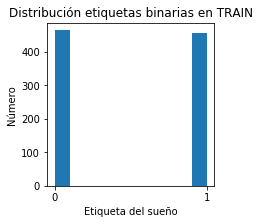

TEST
Número de valores diferentes que hay para etiquetas binarias en TEST: 2 

Número de veces que se toma cada valor de etiquetas binarias en TEST:
1.0    145
0.0    137
Name: Etiquetas binarias, dtype: int64 



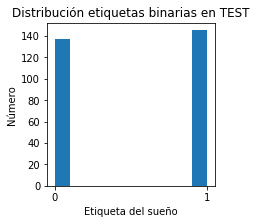

In [33]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas binarias en TRAIN:',Train_bin_balanced['Etiquetas binarias'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas binarias en TRAIN:')
print(Train_bin_balanced['Etiquetas binarias'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Train_bin_balanced['Etiquetas binarias'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas binarias en TEST:',Test_bin_balanced['Etiquetas binarias'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas binarias en TEST:')
print(Test_bin_balanced['Etiquetas binarias'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Test_bin_balanced['Etiquetas binarias'])
plt.show()

SUBCONJUNTOS TRAIN Y TEST NORMALIZADOS

In [34]:
print('Las dimensiones de la matriz de TRAIN sin normalizar es:',Train_tt_bin_balanced.shape)
print('Las dimensiones de la matriz de TEST sin normalizar es:',Test_tt_bin_balanced.shape)
print('\n')
print('Las dimensiones de la matriz de TRAIN con etiquetas binarias normalizadas es:',Train_bin_transformed.shape)
print('Las dimensiones de la matriz de TEST con etiquetas binarias normalizadas es:',Test_bin_transformed.shape)

Las dimensiones de la matriz de TRAIN sin normalizar es: (918, 16)
Las dimensiones de la matriz de TEST sin normalizar es: (282, 16)


Las dimensiones de la matriz de TRAIN con etiquetas binarias normalizadas es: (918, 16)
Las dimensiones de la matriz de TEST con etiquetas binarias normalizadas es: (282, 16)


TRAIN
Número de valores diferentes que hay para etiquetas binarias en TRAIN: 2 

Número de veces que se toma cada valor de etiquetas binarias en TRAIN:
0.0    463
1.0    455
Name: Etiquetas binarias, dtype: int64 



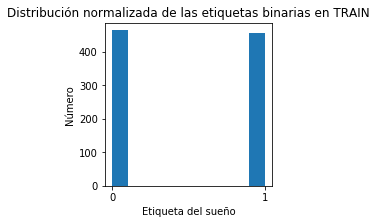

TEST
Número de valores diferentes que hay para etiquetas binarias en TEST: 2 

Número de veces que se toma cada valor de etiquetas binarias en TEST:
1.0    145
0.0    137
Name: Etiquetas binarias, dtype: int64 



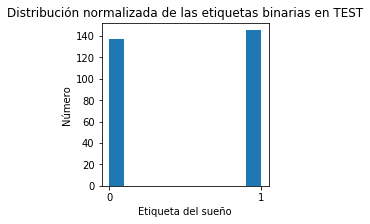

In [35]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas binarias en TRAIN:',Train_bin_transformed['Etiquetas binarias'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas binarias en TRAIN:')
print(Train_bin_transformed['Etiquetas binarias'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución normalizada de las etiquetas binarias en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Train_bin_transformed['Etiquetas binarias'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas binarias en TEST:',Test_bin_transformed['Etiquetas binarias'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas binarias en TEST:')
print(Test_bin_transformed['Etiquetas binarias'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución normalizada de las etiquetas binarias en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Test_bin_transformed['Etiquetas binarias'])
plt.show()

#### ETIQUETAS MULTICLASE

SUBCONJUNTOS TRAIN Y TEST

In [36]:
print('Las dimensiones de la matriz con etiquetas multiclase es:',df_multi_balanced.shape)
print('Las dimensiones de la matriz de TRAIN con etiquetas multiclase es:',Train_multi_balanced.shape)
print('Las dimensiones de la matriz de TEST con etiquetas multiclase es:',Test_multi_balanced.shape)

Las dimensiones de la matriz con etiquetas multiclase es: (1000, 16)
Las dimensiones de la matriz de TRAIN con etiquetas multiclase es: (758, 16)
Las dimensiones de la matriz de TEST con etiquetas multiclase es: (242, 16)


TRAIN
Número de valores diferentes que hay para etiquetas multiclase en TRAIN: 5 

Número de veces que se toma cada valor de etiquetas multiclase en TRAIN:
1.0    157
2.0    154
0.0    152
5.0    149
3.0    146
Name: Etiquetas multiclase, dtype: int64 



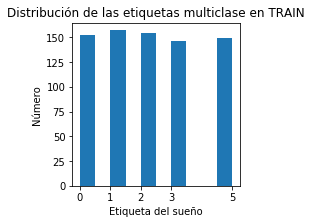

TEST
Número de valores diferentes que hay para etiquetas multiclase en TEST: 5 

Número de veces que se toma cada valor de etiquetas multiclase en TEST:
3.0    54
5.0    51
0.0    48
2.0    46
1.0    43
Name: Etiquetas multiclase, dtype: int64 



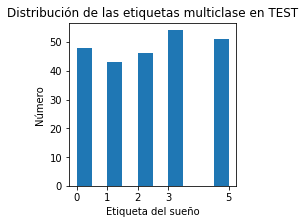

In [37]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas multiclase en TRAIN:',Train_multi_balanced['Etiquetas multiclase'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas multiclase en TRAIN:')
print(Train_multi_balanced['Etiquetas multiclase'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución de las etiquetas multiclase en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Train_multi_balanced['Etiquetas multiclase'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas multiclase en TEST:',Test_multi_balanced['Etiquetas multiclase'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas multiclase en TEST:')
print(Test_multi_balanced['Etiquetas multiclase'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución de las etiquetas multiclase en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Test_multi_balanced['Etiquetas multiclase'])
plt.show()

SUBCONJUNTOS TRAIN Y TEST NORMALIZADOS

In [38]:
print('Las dimensiones de la matriz de TRAIN sin normalizar es:',Train_tt_multi_balanced.shape)
print('Las dimensiones de la matriz de TEST sin normalizar es:',Test_tt_multi_balanced.shape)
print('\n')
print('Las dimensiones de la matriz de TRAIN con etiquetas multiclase normalizadas es:',Train_multi_transformed.shape)
print('Las dimensiones de la matriz de TEST con etiquetas multiclase normalizadas es:',Test_multi_transformed.shape)

Las dimensiones de la matriz de TRAIN sin normalizar es: (758, 16)
Las dimensiones de la matriz de TEST sin normalizar es: (242, 16)


Las dimensiones de la matriz de TRAIN con etiquetas multiclase normalizadas es: (758, 16)
Las dimensiones de la matriz de TEST con etiquetas multiclase normalizadas es: (242, 16)


TRAIN
Número de valores diferentes que hay para etiquetas multiclase en TRAIN: 5 

Número de veces que se toma cada valor de etiquetas multiclase en TRAIN:
1.0    157
2.0    154
0.0    152
5.0    149
3.0    146
Name: Etiquetas multiclase, dtype: int64 



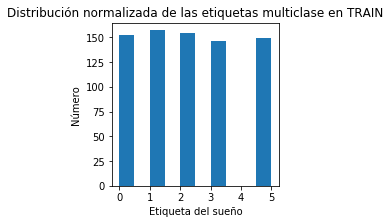

TEST
Número de valores diferentes que hay para etiquetas multiclase en TEST: 5 

Número de veces que se toma cada valor de etiquetas multiclase en TEST:
3.0    54
5.0    51
0.0    48
2.0    46
1.0    43
Name: Etiquetas multiclase, dtype: int64 



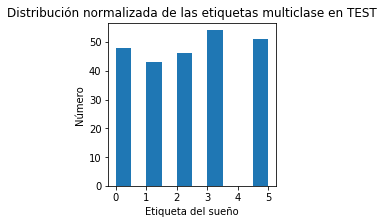

In [39]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas multiclase en TRAIN:',Train_multi_transformed['Etiquetas multiclase'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas multiclase en TRAIN:')
print(Train_multi_transformed['Etiquetas multiclase'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución normalizada de las etiquetas multiclase en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([-1,0,1,2,3,4,5])
plt.hist(Train_multi_transformed['Etiquetas multiclase'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
print('Número de valores diferentes que hay para etiquetas multiclase en TEST:',Test_multi_transformed['Etiquetas multiclase'].nunique(),'\n')
print('Número de veces que se toma cada valor de etiquetas multiclase en TEST:')
print(Test_multi_transformed['Etiquetas multiclase'].value_counts(),'\n')
plt.figure(figsize=(3, 3))
plt.title('Distribución normalizada de las etiquetas multiclase en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([-1,0,1,2,3,4,5])
plt.hist(Test_multi_transformed['Etiquetas multiclase'])
plt.show()

#### SIN BALANCEAR

SUBCONJUNTOS TRAIN Y TEST

In [40]:
print('Las dimensiones de la matriz original sin balancear es:',df.shape)
print('Las dimensiones de la matriz de TRAIN sin balancear es:',Train.shape)
print('Las dimensiones de la matriz de TEST sin balancear es:',Test.shape)

Las dimensiones de la matriz original sin balancear es: (22165, 16)
Las dimensiones de la matriz de TRAIN sin balancear es: (16799, 16)
Las dimensiones de la matriz de TEST sin balancear es: (5366, 16)


TRAIN


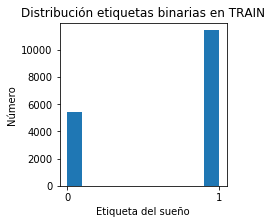

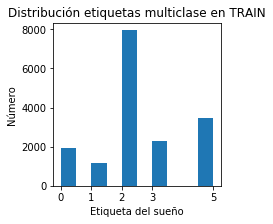

TEST


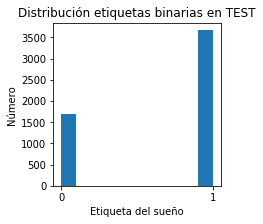

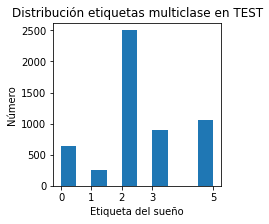

In [41]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Train['Etiquetas binarias'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas multiclase en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Train['Etiquetas multiclase'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Test['Etiquetas binarias'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas multiclase en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Test['Etiquetas multiclase'])
plt.show()

SUBCONJUNTOS TRAIN Y TEST NORMALIZADOS

In [42]:
print('Las dimensiones de la matriz sin balancear normalizada es:',df.shape)
print('Las dimensiones de la matriz de TRAIN sin balancear normalizada es:',Train_transformed.shape)
print('Las dimensiones de la matriz de TEST sin balancear normalizada es:',Test_transformed.shape)

Las dimensiones de la matriz sin balancear normalizada es: (22165, 16)
Las dimensiones de la matriz de TRAIN sin balancear normalizada es: (16799, 16)
Las dimensiones de la matriz de TEST sin balancear normalizada es: (5366, 16)


TRAIN


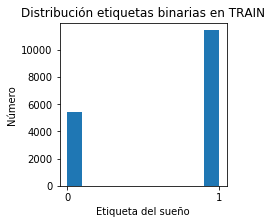

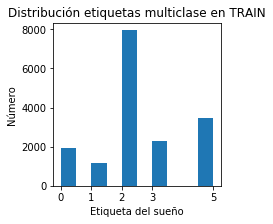

TEST


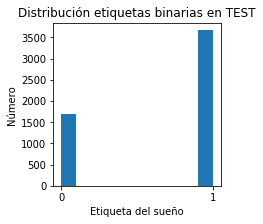

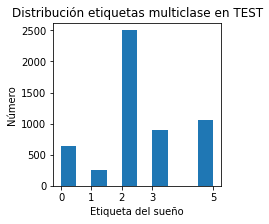

In [43]:
print('\x1b[1;30m'+'TRAIN'+'\x1b[0m')

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Train_transformed['Etiquetas binarias'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas multiclase en TRAIN')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Train_transformed['Etiquetas multiclase'])
plt.show()

print('\x1b[1;30m'+'TEST'+'\x1b[0m')
plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas binarias en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1])
plt.hist(Test_transformed['Etiquetas binarias'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución etiquetas multiclase en TEST')
plt.xlabel("Etiqueta del sueño")
plt.ylabel("Número")
plt.xticks([0,1,2,3,5])
plt.hist(Test_transformed['Etiquetas multiclase'])
plt.show()